# Mass Transfer Lab COMSOL Data Analysis

#### Import libraries 

In [8]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import interp1d

#### Reading csv data and cleaning

In [9]:
df_123 = pd.read_csv('123_data.csv')
df_128 = pd.read_csv('128_data.csv')
df_133 = pd.read_csv('133_data.csv')
df_140 = pd.read_csv('140_FINER_DATA.csv')

def cleaner(df):
    df = df.dropna()
    df = df.rename(columns=df.iloc[0]).drop(df.index[0]).reset_index(drop=True)
    df = df.apply(pd.to_numeric, errors='coerce')
    df = df.rename(columns={"% x": "x (m)", "y": "y (m)"})
    return df

df_123 = cleaner(df_123)
df_128 = cleaner(df_128)
df_133 = cleaner(df_133)
df_140 = cleaner(df_140)
df_123.head()

,x (m),y (m),T (K),c (mol/m^3)
0,0.000000,0.001165,316.538890,0.000000
1,0.000000,0.000547,316.538890,0.000000
2,0.000889,0.000946,316.531245,0.000914
3,0.001411,0.001557,316.537820,0.000152
4,0.000000,0.002294,316.538890,0.000000


#### Dataframe for molar flux

In [10]:
flux_data = [-0.0017986, -0.0019379, -0.0020889, -0.0019698]
mflux_df = pd.DataFrame(flux_data, columns=["molar flux"])
mflux_df

,molar flux
0,-0.001799
1,-0.001938
2,-0.002089
3,-0.001970


# Analysis Question 2
Determine the thicknesses of both thermal and concentration boundary layers and how they
vary with position x (at a fixed velocity) as well as with velocity (at a fixed position or
average along various positions). Clearly describe how you determine the boundary-layer
thickness. Explain the trends and what you expect based on theory, and the physical
reasoning of such trends. Please avoid nonlinear fits (because in general they do not
guarantee a unique solution and can be difficult to judge visually because subtleties in
curvature can be unobvious) and instead linearize your equations so as to enable use of
linear least-squares regression (which has a unique solution and is intuitive to judge
visually).

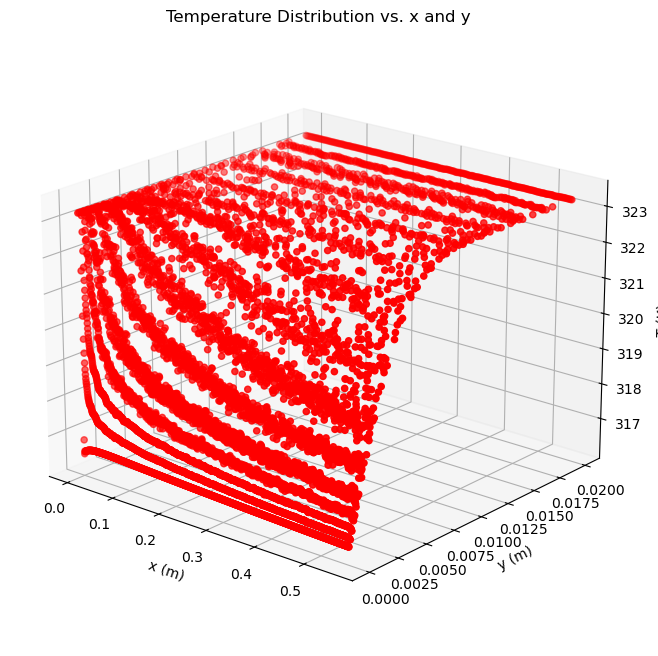

In [11]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of the data points
ax.scatter(df_140['x (m)'], df_140['y (m)'], df_140['T (K)'], c='r', marker='o')

# Set labels for the axes
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_zlabel('T (K)')

# Set a title for the plot
ax.set_title('Temperature Distribution vs. x and y')

# Rotate the plot for better visualization (optional)
ax.view_init(elev=20, azim=-50)  # Adjust elevation and azimuth angles

# Display the plot
plt.show()

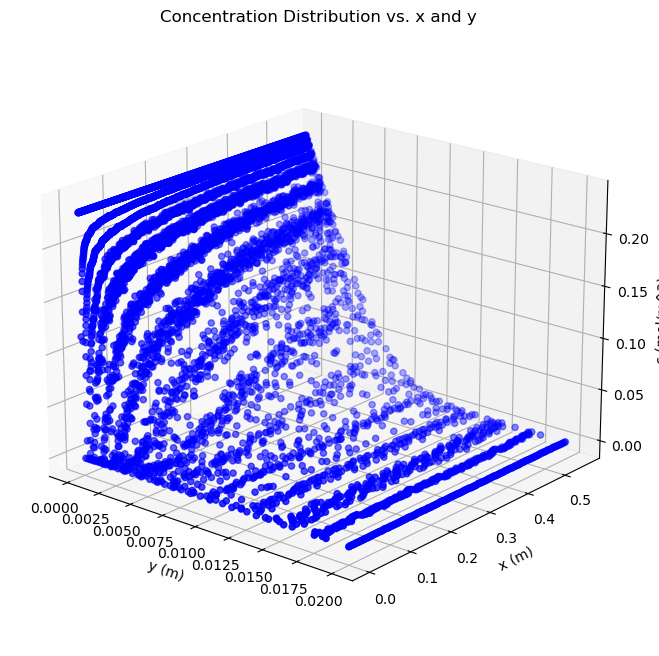

In [12]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of the data points
ax.scatter(df_140['y (m)'], df_140['x (m)'], df_140['c (mol/m^3)'], c='b', marker='o')

# Set labels for the axes
ax.set_xlabel('y (m)')
ax.set_ylabel('x (m)')
ax.set_zlabel('c (mol/m^3)')

# Set a title for the plot
ax.set_title('Concentration Distribution vs. x and y')

# Rotate the plot for better visualization (optional)
ax.view_init(elev=20, azim=-50)  # Adjust elevation and azimuth angles

# Display the plot
plt.show()

#### Thermal Boundary Layer Thickness Determination

In [13]:
def find_thermal_boundary_layer_thickness_max_temp(df, threshold=0.99):
    """
    Calculate thermal boundary layer thickness at each x position based on maximum temperature.
    
    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame with columns "x (m)", "y (m)", "T (K)"
    threshold : float, optional
        Threshold for boundary layer thickness (default: 0.99)
        
    Returns:
    --------
    x_positions : numpy array
        Unique x positions
    thicknesses : numpy array
        Thermal boundary layer thickness at each x position
    """
    # Get unique x positions
    x_positions = df["x (m)"].unique()
    x_positions.sort()
    
    # Initialize array to store boundary layer thicknesses
    thicknesses = np.zeros(len(x_positions))
    
    # Process each x position separately
    for i, x_pos in enumerate(x_positions):
        # Get data for this x position only
        x_data = df[df["x (m)"] == x_pos].sort_values(by="y (m)")
        
        # Extract y coordinates and temperatures for this x position
        y_coords = x_data["y (m)"].values
        temps = x_data["T (K)"].values
        
        # Find maximum temperature and its position
        max_temp = temps.max()
        max_temp_idx = np.argmax(temps)
        max_temp_y = y_coords[max_temp_idx]
        
        # Get freestream temperature (at maximum y)
        freestream_temp = temps[-1]
        
        # Temperature difference from max to freestream
        delta_T = abs(freestream_temp - max_temp)
        
        # Calculate the threshold temperature (99% recovery from maximum)
        if max_temp > freestream_temp:
            threshold_temp = max_temp - threshold * delta_T
        else:
            threshold_temp = max_temp + threshold * delta_T
        
        # Find where temperature reaches threshold
        thickness_found = False
        
        # Only look at positions beyond the maximum temperature location
        for j in range(max_temp_idx + 1, len(y_coords)):
            if ((max_temp > freestream_temp and temps[j] <= threshold_temp) or
                (max_temp < freestream_temp and temps[j] >= threshold_temp)):
                # Linear interpolation to find more precise y value
                y1, y2 = y_coords[j-1], y_coords[j]
                t1, t2 = temps[j-1], temps[j]
                
                # Interpolate to find y where temp = threshold_temp
                thicknesses[i] = y1 + (y2 - y1) * (threshold_temp - t1) / (t2 - t1)
                thickness_found = True
                break
        
        # If we didn't find a crossing point, use the maximum y value
        if not thickness_found:
            thicknesses[i] = y_coords[-1]
            print(f"Warning: Could not find threshold at x = {x_pos}. Using maximum y value.")
    
    return x_positions, thicknesses

#### For the smallest air velocity

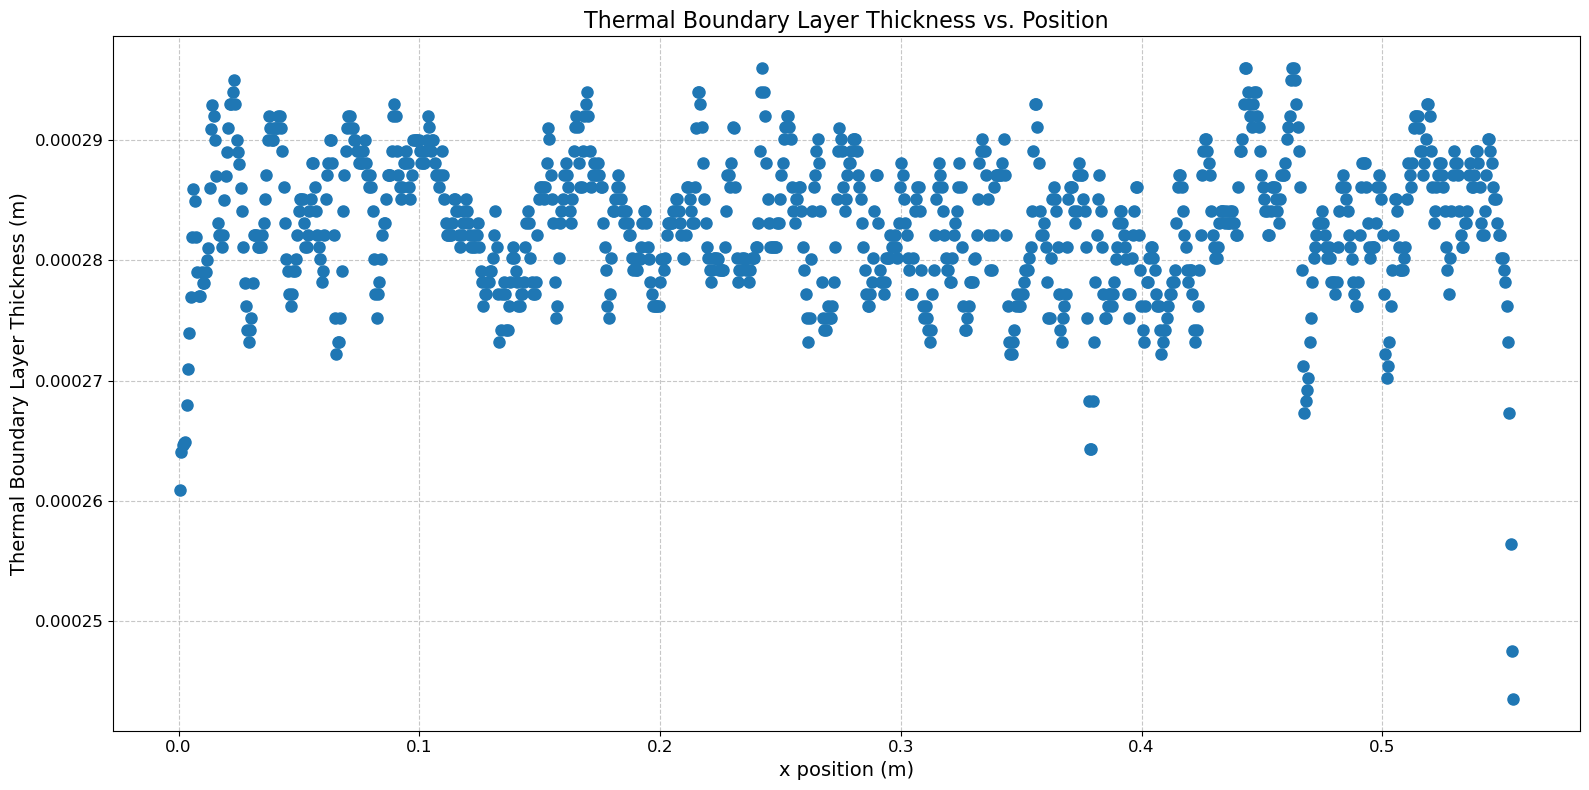

,x (m),thermal_boundary_layer_thickness (m)
0,0.00056,0.000261
1,0.00112,0.000264
2,0.00168,0.000265
3,0.00224,0.000265
4,0.00280,0.000265


In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Get unique x positions
x_positions = df_140['x (m)'].unique()
x_positions.sort()

# Dictionary to store boundary layer thickness at each x position
thermal_bl_thickness = {}

# For each x position
for x in x_positions:
    # Skip the problematic position at x = 0.555
    if abs(x - 0.555) < 1e-6:
        continue
        
    # Get temperature data for this x position
    x_data = df_140[df_140['x (m)'] == x].sort_values(by='y (m)')
    
    # Get y and T values
    y_values = x_data['y (m)'].values
    T_values = x_data['T (K)'].values
    
    # Skip if we don't have enough data points
    if len(y_values) < 2:
        continue
    
    # Find free-stream temperature (maximum temperature)
    T_freestream = T_values.max()
    
    # Find wall temperature (minimum temperature)
    T_wall = T_values.min()
    
    # Skip if there's no temperature difference
    if T_freestream == T_wall:
        continue
    
    # Define thermal boundary layer as where T reaches 99% of (T_freestream - T_wall)
    T_threshold = T_wall + 0.99 * (T_freestream - T_wall)
    
    try:
        # Create interpolation function
        interp_func = interp1d(T_values, y_values, bounds_error=False, fill_value="extrapolate")
        
        # Get boundary layer thickness
        delta_t = float(interp_func(T_threshold))
        
        # Only store valid values
        if not np.isnan(delta_t) and delta_t > 0:
            thermal_bl_thickness[x] = delta_t
    except:
        # Skip if interpolation fails
        continue

# Create a dataframe with the results
result_df = pd.DataFrame({
    'x (m)': list(thermal_bl_thickness.keys()),
    'thermal_boundary_layer_thickness (m)': list(thermal_bl_thickness.values())
})

# Sort the results by x position
result_df = result_df.sort_values(by='x (m)')

# Plot the thermal boundary layer thickness vs x position
plt.figure(figsize=(16, 8))  # Increased width from 10 to 16

# Plot with improved styling
plt.plot(result_df['x (m)'], result_df['thermal_boundary_layer_thickness (m)'], 'o', 
         linewidth=2, markersize=8, color='#1f77b4')

# Enhance the plot appearance
plt.xlabel('x position (m)', fontsize=14)
plt.ylabel('Thermal Boundary Layer Thickness (m)', fontsize=14)
plt.title('Thermal Boundary Layer Thickness vs. Position', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tick_params(axis='both', which='major', labelsize=12)

# Add tight layout to make better use of space
plt.tight_layout()

# Show the plot
plt.show()

# Display the results
result_df.head()

Power law relationship: δₜ = 0.000283 · x^0.000282
R-squared value: 0.000179
The exponent is 0.0003, which differs from typical laminar (0.5) or turbulent (0.8) values.
This could indicate transitional flow or other physical phenomena affecting boundary layer growth.


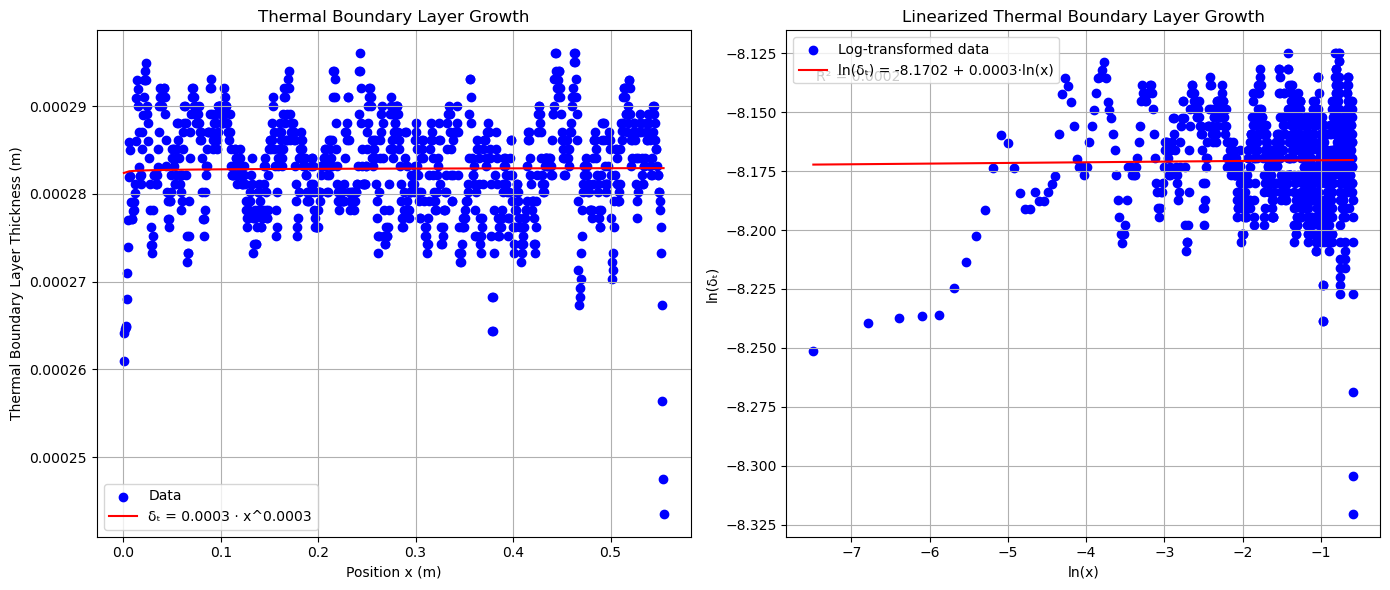

In [15]:
x_column = 'x (m)'
thickness_column = 'thermal_boundary_layer_thickness (m)'

# Create log-transformed data
log_x = np.log(result_df[x_column])
log_thickness = np.log(result_df[thickness_column])

# Perform linear regression on log-transformed data
slope, intercept, r_value, p_value, std_err = stats.linregress(log_x, log_thickness)

# Calculate the power law coefficient
coefficient = np.exp(intercept)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Original data with power law fit
x_range = np.linspace(min(result_df[x_column]), max(result_df[x_column]), 100)
power_law = coefficient * x_range**slope

ax1.scatter(result_df[x_column], result_df[thickness_column], 
           color='blue', label='Data')
ax1.plot(x_range, power_law, 'r-', label=f'δₜ = {coefficient:.4f} · x^{slope:.4f}')
ax1.set_xlabel('Position x (m)')
ax1.set_ylabel('Thermal Boundary Layer Thickness (m)')
ax1.set_title('Thermal Boundary Layer Growth')
ax1.legend()
ax1.grid(True)

# Plot 2: Linearized data with linear fit
ax2.scatter(log_x, log_thickness, color='blue', label='Log-transformed data')
ax2.plot(log_x, intercept + slope*log_x, 'r-', 
        label=f'ln(δₜ) = {intercept:.4f} + {slope:.4f}·ln(x)')
ax2.set_xlabel('ln(x)')
ax2.set_ylabel('ln(δₜ)')
ax2.set_title('Linearized Thermal Boundary Layer Growth')
ax2.legend()
ax2.grid(True)

# Add R-squared value to the plot
ax2.text(0.05, 0.9, f'R² = {r_value**2:.4f}', transform=ax2.transAxes)

# Display the results
print(f"Power law relationship: δₜ = {coefficient:.6f} · x^{slope:.6f}")
print(f"R-squared value: {r_value**2:.6f}")

# Interpret the results based on theory
if abs(slope - 0.5) < 0.1:
    print("The exponent is close to 0.5, suggesting laminar flow conditions.")
elif abs(slope - 0.8) < 0.1:
    print("The exponent is close to 0.8, suggesting turbulent flow conditions.")
else:
    print(f"The exponent is {slope:.4f}, which differs from typical laminar (0.5) or turbulent (0.8) values.")
    print("This could indicate transitional flow or other physical phenomena affecting boundary layer growth.")

plt.tight_layout()
plt.show()